# KERAS LSTM으로 다변수 시계열 예측

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

1. 대기오염 예측
2. 기초데이터 준비
3. 다변수 LSTM 예측 모델
    - LSTM 데이터 준비 
    - Define and Fit Model
    - Evaluate Model
    - 완료
4. 여러 지연 시간 단계에서 학습 예제

준비

- Python SciPy
- Python 3 
- Keras (2.0 or higher)
- TensorFlow or Theano backend, Ideally Keras 2.3 and TensorFlow 2.2, or higher.
- scikit-learn, Pandas, NumPy and Matplotlib

## 1. 대기오염 예측

중국 베이징에있는 미국 대사관에서 5 년 동안 매시간 날씨와 오염 수준을보고하는 데이터 세트.
데이터에는 날짜-시간, PM2.5 농도라고하는 오염, 이슬점, 온도, 기압, 풍향, 풍속, 눈과 비의 누적 시간 등의 날씨 정보 포함

1. No: row number
2. year: year of data in this row
3. month: month of data in this row
4. day: day of data in this row
5. hour: hour of data in this row
6. pm2.5: PM2.5 concentration
7. DEWP: Dew Point
8. TEMP: Temperature
9. PRES: Pressure
10. cbwd: Combined wind direction
11. Iws: Cumulated wind speed
12. Is: Cumulated hours of snow
13. Ir: Cumulated hours of rain


## 2. 기초데이터 준비


https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv

- 위 데이터를 raw.csv로 저장 (2010~2014 5년치 매일매시 데이터 약 43800건)
- 처리 후 pollution.csv로 저장 

- 데이터 시각화 해보기

In [49]:
from pandas import read_csv
from datetime import datetime

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

# 데이러 로드(load)
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)

# 컬럼명을 정의해 준다
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

# NA 데이터를 0 으로 설정
dataset['pollution'].fillna(0, inplace=True)

# 처음 24시간을 drop
dataset = dataset[24:]

# 첫5행 보여주기
print(dataset.head(5))

# 파일 저장
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


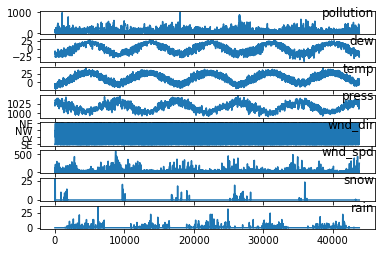

In [50]:
# 데이터셋 읽기
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

# plot 데이터 설정
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1

# 각 컬럼을 plot
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

# 3. 다변수 LSTM 예측 모델

In [51]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

#from tensorflow.keras import backend
#from keras import backend

In [52]:
# series를 지도학습으로 (supervised learning)
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    
    cols, names = list(), list()
    print("="*50)
    print("cols, names")
    print(cols, names)
    
    # 입력값의 순서 (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # 예측의 순서 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # 합치기
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # NaN 값의 row를 제거
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg


In [53]:
# dataset 로딩
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

# 문자를 0부터 시작하는 정수로 바꿔준다
encoder = LabelEncoder()
#범주형 wind_dir 변수를 숫자로 인코딩 해 준다
values[:,4] = encoder.fit_transform(values[:,4])

# 모든 데이터를 float로
values = values.astype('float32')

# features 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


In [54]:
scaled

array([[0.12977867, 0.35294122, 0.24590163, ..., 0.00229001, 0.        ,
        0.        ],
       [0.14889336, 0.36764708, 0.24590163, ..., 0.00381099, 0.        ,
        0.        ],
       [0.15995975, 0.4264706 , 0.22950819, ..., 0.00533197, 0.        ,
        0.        ],
       ...,
       [0.01006036, 0.2647059 , 0.26229507, ..., 0.41399646, 0.        ,
        0.        ],
       [0.00804829, 0.2647059 , 0.24590163, ..., 0.4208665 , 0.        ,
        0.        ],
       [0.01207243, 0.2794118 , 0.26229507, ..., 0.42621556, 0.        ,
        0.        ]], dtype=float32)

In [55]:
dataset

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [56]:
# 지도학습 프레임으로 (함수)
#t-1시점,t시점 데이터를 한 행으로 둔다
reframed = series_to_supervised(scaled, 1, 1)

print('======================= reframed ==========================')
print('컬럼 삭제 이전 확인')
print(reframed.head())
print('컬럼 삭제 이전 확인')


# 예측(predict)을 하지 않을 컬럼 제거
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

# series_to_supervised함수의 n_in,n_out에 따라 가져올 시점의 데이터가 달라진다 
# (만약 n_in = 3, n_out = 3이라면 t-3 , t-2 , t-1 , t , t+1 , t+2 시점의 데이터가 하나의 행이 된다)

print('======================= reframed ==========================')
print(reframed.head())

cols, names
[] []
======================= reframed ==========================
컬럼 삭제 이전 확인
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
1   0.000000        0.0  0.148893  0.367647  0.245902  0.527273  0.666667   
2   0.000000        0.0  0.159960  0.426471  0.229508  0.545454  0.666667   
3   0.000000        0.0  0.182093  0.485294  0.229508  0.563637  0.666667   
4   0.037037        0.0  0.138833  0.485294  0.229508  0.563637  0.666667   
5   0.074074        0.0  0.109658  0.485294  0.213115  0.563637  0.666667   

    var6(t)   var7(t

In [57]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658
...,...,...,...,...,...,...,...,...,...
43795,0.010060,0.264706,0.278689,0.763638,0.333333,0.385730,0.000000,0.0,0.008048
43796,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0,0.010060
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0,0.010060
43798,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0,0.008048


In [58]:
# train and test sets으로 나누기
values = reframed.values
# 1년치 데이터만 가져 옮 (2010년도)
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

print('======================== reframed ==========================')
print(len(train))
print(len(test))


======================== reframed ==========================
8760
35039


In [59]:
# train

In [60]:

# 입력값과 출력값으로 분리
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print('================ shape of train_X ==========================')
print(train_X.shape)
print(train_X[:5])


================ shape of train_X ==========================
(8760, 8)
[[0.12977867 0.35294122 0.24590163 0.5272732  0.6666667  0.00229001
  0.         0.        ]
 [0.14889336 0.36764708 0.24590163 0.5272732  0.6666667  0.00381099
  0.         0.        ]
 [0.15995975 0.4264706  0.22950819 0.545454   0.6666667  0.00533197
  0.         0.        ]
 [0.18209255 0.48529413 0.22950819 0.5636368  0.6666667  0.00839101
  0.03703704 0.        ]
 [0.13883299 0.48529413 0.22950819 0.5636368  0.6666667  0.00991199
  0.07407407 0.        ]]


In [61]:
# 입력값 3D로 reshape [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print('================ reshape 후 train_X 의 shape ===============')
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

================ reshape 후 train_X 의 shape ===============
(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


In [62]:
print(train_X.shape[1])
print(train_X.shape[2])

1
8


In [63]:
# network 디자인
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')


In [64]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/50
122/122 - 1s - loss: 0.0574 - val_loss: 0.0508
Epoch 2/50
122/122 - 0s - loss: 0.0417 - val_loss: 0.0520
Epoch 3/50
122/122 - 0s - loss: 0.0242 - val_loss: 0.0428
Epoch 4/50
122/122 - 0s - loss: 0.0164 - val_loss: 0.0313
Epoch 5/50
122/122 - 0s - loss: 0.0150 - val_loss: 0.0197
Epoch 6/50
122/122 - 0s - loss: 0.0150 - val_loss: 0.0171
Epoch 7/50
122/122 - 0s - loss: 0.0148 - val_loss: 0.0159
Epoch 8/50
122/122 - 0s - loss: 0.0146 - val_loss: 0.0149
Epoch 9/50
122/122 - 0s - loss: 0.0146 - val_loss: 0.0147
Epoch 10/50
122/122 - 0s - loss: 0.0147 - val_loss: 0.0145
Epoch 11/50
122/122 - 1s - loss: 0.0145 - val_loss: 0.0139
Epoch 12/50
122/122 - 1s - loss: 0.0146 - val_loss: 0.0139
Epoch 13/50
122/122 - 1s - loss: 0.0146 - val_loss: 0.0139
Epoch 14/50
122/122 - 0s - loss: 0.0146 - val_loss: 0.0137
Epoch 15/50
122/122 - 1s - loss: 0.0145 - val_loss: 0.0135
Epoch 16/50
122/122 - 0s - loss: 0.0145 - val_loss: 0.0134
Epoch 17/50
122/122 - 1s - loss: 0.0146 - val_loss: 0.0135
Epoch 

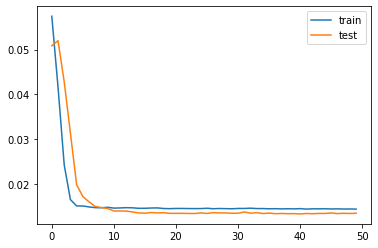

예측성능 비교지표 RMSE: 26.443


In [65]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
# https://blog.naver.com/lyb0684/221745858928     특정 확률분포를 따르는 난수생성
# https://www.youtube.com/watch?v=OYn-Mg2Sg20    6분
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# RMSE(Root Mean Square Error) 계산
# https://artwook.tistory.com/152
# https://blog.naver.com/jaysrogers/221737694744
# https://www.statisticshowto.com/probability-and-statistics/regression-analysis/rmse-root-mean-square-error/
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('예측성능 비교지표 RMSE: %.3f' % rmse)

## 4. 여러 지연 시간 단계에서 학습 예제

여러 이전 시간 단계에서 모델을 학습하는 데 필요한 변경 사항은 다음과 같이 매우 적다

- series_to_supervised ()를 호출 할 때 문제를 적절하게 구성
- 3 시간의 데이터를 입력으로 사용
- ob (t)의 다른 모든 필드에서 더 이상 명시 적으로 열을 삭제 안함

### specify the number of lag hours
n_hours = 3
n_features = 8
### frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)

- 입력 및 출력을위한 열을 지정하는 데 주의
- 프레임 데이터 세트에는 3 * 8 + 8 개의 열
- 이전 3 시간 동안 모든 기능의 obs에 대한 입력으로 3 * 8 또는 24 개 열을 사용
- 오염 변수를 다음 시간에 출력으로 취합

### split into input and outputs
n_obs = n_hours * n_features

train_X, train_y = train[:, :n_obs], train[:, -n_features]

test_X, test_y = test[:, :n_obs], test[:, -n_features]

print(train_X.shape, len(train_X), train_y.shape)

입력 데이터를 올바르게 재구성하여 시간 단계와 기능을 반영

### reshape input to be 3D [samples, timesteps, features]

train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))

test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

모델 피팅은 동일

- 유일한 다른 작은 변화는 모델을 평가하는 방법
- RMSE를 계산할 수 있도록 y 및 yhat을 원래 스케일로 되돌리기 위해 스케일링 작업을 반전하는 데 적합한 8 개 열로 행을 재구성하는 방법

- 변경의 요지는 다음과 같이 스케일링을 역전시키기 위해 y 또는 yhat 열을 테스트 데이터 세트의 마지막 7 개 기능과 연결

### invert scaling for forecast

inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)

inv_yhat = scaler.inverse_transform(inv_yhat)

inv_yhat = inv_yhat[:,0]

### invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))

inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)

inv_y = scaler.inverse_transform(inv_y)

inv_y = inv_y[:,0]

# 전체 코드

## 4. 여러 지연 시간 단계에서 학습 예제

In [66]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [67]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


In [68]:
# specify the number of lag hours
n_hours = 3
n_features = 8

# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)


(43797, 32)


In [69]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]


In [70]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)


(8760, 24) 8760 (8760,)


In [71]:
# n_hours => 3 n_features => 8 
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 3, 8) (8760,) (35037, 3, 8) (35037,)


In [78]:
print(train_X.shape[1], train_X.shape[2])

3 8


In [73]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')


In [74]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/50
122/122 - 1s - loss: 0.0508 - val_loss: 0.0683
Epoch 2/50
122/122 - 1s - loss: 0.0273 - val_loss: 0.0388
Epoch 3/50
122/122 - 1s - loss: 0.0215 - val_loss: 0.0267
Epoch 4/50
122/122 - 1s - loss: 0.0209 - val_loss: 0.0231
Epoch 5/50
122/122 - 1s - loss: 0.0207 - val_loss: 0.0217
Epoch 6/50
122/122 - 1s - loss: 0.0201 - val_loss: 0.0199
Epoch 7/50
122/122 - 1s - loss: 0.0198 - val_loss: 0.0189
Epoch 8/50
122/122 - 1s - loss: 0.0188 - val_loss: 0.0189
Epoch 9/50
122/122 - 1s - loss: 0.0191 - val_loss: 0.0181
Epoch 10/50
122/122 - 1s - loss: 0.0186 - val_loss: 0.0182
Epoch 11/50
122/122 - 1s - loss: 0.0180 - val_loss: 0.0178
Epoch 12/50
122/122 - 1s - loss: 0.0176 - val_loss: 0.0176
Epoch 13/50
122/122 - 1s - loss: 0.0174 - val_loss: 0.0176
Epoch 14/50
122/122 - 1s - loss: 0.0169 - val_loss: 0.0185
Epoch 15/50
122/122 - 1s - loss: 0.0166 - val_loss: 0.0178
Epoch 16/50
122/122 - 1s - loss: 0.0161 - val_loss: 0.0181
Epoch 17/50
122/122 - 1s - loss: 0.0160 - val_loss: 0.0180
Epoch 

In [77]:
test_X.shape

(35037, 24)

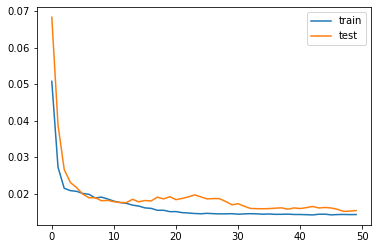

ValueError: in user code:

    C:\Users\JSSON\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Users\JSSON\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\JSSON\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\JSSON\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\JSSON\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\JSSON\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Users\JSSON\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Users\JSSON\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\JSSON\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:176 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_5 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 24]


In [79]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
yhat

In [ ]:
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

## error 조치

pip install --upgrade tensorflow

python3 -m pip install --upgrade pip

pip install -U keras